In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
#  mounts the Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# test path from the drive
test_path = '/content/drive/MyDrive/Kaggle/Digit_Recognizer/test.csv'

In [6]:
# train path from the drive
train_path = '/content/drive/MyDrive/Kaggle/Digit_Recognizer/train.csv'

In [5]:
# copying the file from drive to colab
!cp "{test_path}" .

In [7]:
# copying the file from drive to colab
!cp "{train_path}" .

In [8]:
test_df = pd.read_csv('test.csv')

In [9]:
train_df = pd.read_csv('train.csv')

In [11]:
train_df.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
train_df.shape

(42000, 785)

In [13]:
test_df.shape

(28000, 784)

In [14]:
# Drop 'label' column
X_train = train_df.drop(labels = ["label"],axis = 1) 

In [15]:
# only label column
Y_train = train_df["label"]

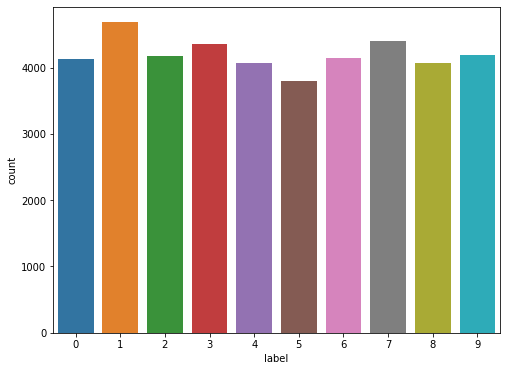

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(x = Y_train)
plt.show()

In [17]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [ ]:
X_train = X_train.values.reshape(-1,28,28,1)
g = plt.imshow(X_train[0][:,:,0])

## Preprocessing Data

In [ ]:
Y_train


Our labels are literally categories of numbers. We need to translate this to be "one hot encoded" so our CNN can understand, otherwise it will think this is some sort of regression problem on a continuous axis. Keras has an easy to use function for this:

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:

Y_train_cat = to_categorical(Y_train)

In [ ]:
print(Y_train_cat[0])

### Processing X Data

In [ ]:
X_train[0][:,:,0].max()

In [ ]:
X_train[0][:,:,0].min()

We should normalize the X data

In [ ]:
plt.imshow(X_train[1729][0])